<a href="https://colab.research.google.com/github/HyberionBrew/ASPP-accelerator/blob/main/vae_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls 

drive  sample_data


In [ ]:
!cp drive/MyDrive/dataset.zip dataset.zip

In [ ]:
%%capture
!unzip dataset.zip

In [ ]:
!ls dataset

after  after_label  before  before_label  diff_label


In [ ]:
%%capture
!pip install rasterio
!pip install geopandas
!pip install albumentations==0.4.6

In [ ]:
!git clone https://github.com/hsiangyuzhao/Segmentation-Metrics-PyTorch.git

Cloning into 'Segmentation-Metrics-PyTorch'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 24 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [ ]:
!cp Segmentation-Metrics-PyTorch/metric.py metric.py

In [ ]:
from metric import BinaryMetrics

In [ ]:
!git clone https://github.com/milesial/Pytorch-UNet

Cloning into 'Pytorch-UNet'...
remote: Enumerating objects: 530, done.
remote: Total 530 (delta 0), reused 0 (delta 0), pack-reused 530
Receiving objects: 100% (530/530), 47.40 MiB | 16.68 MiB/s, done.
Resolving deltas: 100% (276/276), done.


In [ ]:
!ls unet

ls: cannot access 'unet': No such file or directory


In [ ]:
!cp -r Pytorch-UNet/unet/ unet/

In [ ]:
import sys
import os
sys.path.append(os.path.abspath("unet/*"))
from unet.unet_parts import *
from unet.unet_model import UNet

In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import rasterio as rio
from rasterio import features
from pathlib import Path
import pathlib
import geopandas as gpd
from descartes import PolygonPatch
from PIL import Image
import itertools
import re
from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# import imgaug
import random
import albumentations

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

%matplotlib inline

In [ ]:
import cv2

In [ ]:
total_indx = 2
img1 = cv2.imread('./dataset/before/%06d.png'%total_indx)
img2 = cv2.imread('./dataset/after/%06d.png'%total_indx)
mask1 = torch.load('./dataset/before_label/%06d.pth'%total_indx)
mask2 = torch.load('./dataset/after_label/%06d.pth'%total_indx)
mask_diff = torch.load('./dataset/diff_label/%06d.pth'%total_indx)

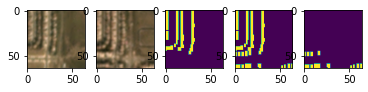

In [ ]:
# plt.figure(figsize=(4, 4), dpi=80)
plt.subplot(2, 5, 1)
plt.imshow(img1)

plt.subplot(2, 5, 2)
plt.imshow(img2)

plt.subplot(2, 5, 3)
plt.imshow(mask1)

plt.subplot(2, 5, 4)
plt.imshow(mask2)
plt.subplot(2, 5, 5)
plt.imshow(mask_diff)

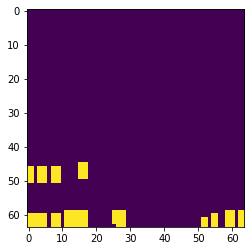

In [ ]:
#%%
plt.imshow(mask_diff)

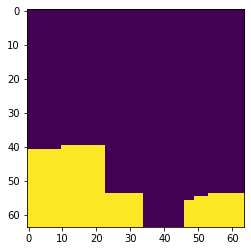

In [ ]:
plt.imshow(cv2.GaussianBlur(mask_diff.astype(float),(11, 11), 0) > 0.)

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
#%%
import glob

In [ ]:
paths = glob.glob('./dataset/before/*')


In [ ]:
class MyDataset(Dataset):
    def __init__(self, transform=None):
        self.paths = glob.glob('./dataset/before/*')
        self.transform = transform
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img1 = cv2.imread(self.paths[idx])
        img2 = cv2.imread(self.paths[idx].replace('before','after'))
        label2 = torch.load(self.paths[idx].replace('before','diff_label').replace('png','pth'))
        # why do we use label2 here?
        #label1 = torch.load(self.paths[idx].replace('before','before_label').replace('png','pth')) 
        label1 = cv2.GaussianBlur(label2.astype(float),(11, 11), 0) > 0.
        #label1 = cv2.GaussianBlur(label2.astype(float),(11, 11), 0) > 0.
        if self.transform:
            transformed1 = self.transform(image = img1,label = label1)
            transformed2 = self.transform(image = img2,label = label2)
        img1 = transformed1['image']
        label1 = transformed1['label']
        img2 = transformed2['image']
        label2 = transformed2['label']
        return img1,img2, label1,label2


In [ ]:
transform = A.Compose(
    [
        A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2()
    ]
)

In [ ]:
dataset = MyDataset(transform)
img1,img2, label1,label2 = dataset[2000]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


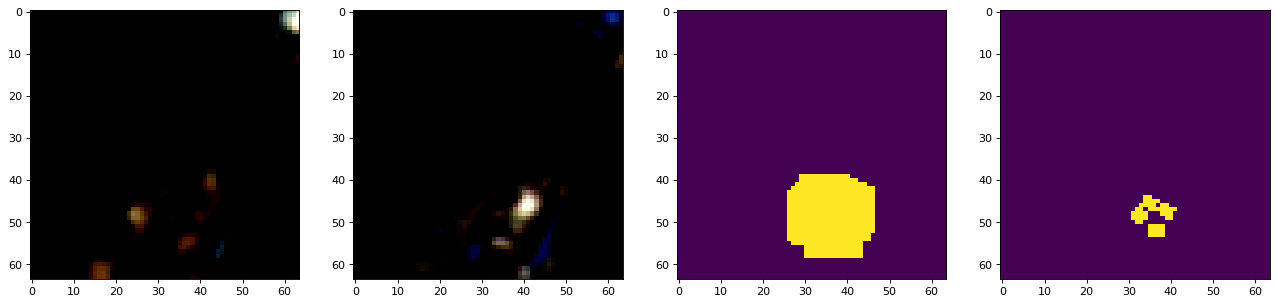

In [ ]:
plt.figure(figsize=(20, 20), dpi=80)
plt.subplot(2, 4, 1)
plt.imshow(img1.permute(1,2,0))

plt.subplot(2, 4, 2)
plt.imshow(img2.permute(1,2,0))

plt.subplot(2, 4, 3)
plt.imshow(label1)

plt.subplot(2, 4, 4)
plt.imshow(label2)

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
import math

train_size = math.floor(0.8 * len(dataset))
test_size = len(dataset)- train_size

np.random.seed(42)
indices = list(range(len(dataset)))
np.random.shuffle(indices)
val_indices,train_indices = indices[train_size:], indices[:train_size]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(val_indices)

batch_size = 32
num_workers = 3
train_loader = DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=num_workers)
test_loader = DataLoader(dataset, batch_size=batch_size,
                                                sampler=test_sampler, num_workers=num_workers)

In [ ]:
#dataloader = DataLoader(dataset, batch_size=8,
#                        shuffle=False, num_workers=3)

In [ ]:
model = UNet(4,1).cuda()
#model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5)

In [ ]:
#optimizer = torch.optim.SGD(model.parameters(),
#                            lr=1e-3,
#                            momentum=4e-5,
#                            weight_decay=0.9)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-5, weight_decay=1e-8, momentum=0.9)

In [ ]:
#loss_function = torch.nn.MSELoss().cuda() # 
loss_function = torch.nn.BCEWithLogitsLoss().cuda()

In [ ]:
def metric(outputs: torch.Tensor, labels: torch.Tensor):
    # y_true: (N, H, W)
    # y_pred: (N, 1, H, W)
    bn = BinaryMetrics()
    metrics = bn(labels,outputs)
    #print(metrics)
    return metrics

In [ ]:
pixel_acc_all = []
dice_all = [] 
precision_all = [] 
specificity_all = [] 
recall_all = []

def test_loop(model, test_dataset):
    computeExample = True
    example = np.zeros((batch_size,64,64))
    example_label = torch.tensor(np.zeros((batch_size,64,64)))
    input_label = None
    for img1,img2, label1,label2 in tqdm(test_dataset):
        img1 = img1.type(torch.float32).cuda()
        img2 = img2.type(torch.float32).cuda()
        label1 = label1.cuda()
        label2 = label2.cuda()
        with torch.no_grad():
            #sig = torch.nn.Sigmoid()
            output = model(torch.cat([img1,label1.unsqueeze(1).type(torch.float32)],dim=1))
            out_mask = output#output[:,-1,:,:]
            #print(f"outmask {out_mask.shape}")
            #out_mask = sig(out_mask.unsqueeze(1))
        #out_image = output[:,:-1,:,:]
       
         # torch.nn.functional.softmax(out_mask, dim=)
        final_mask = out_mask.cpu() #.detach().numpy()
        #print(f"outmask {final_mask.shape}")
        #final_mask = np.zeros_like(det_mask)
        #final_mask[det_mask>0.5] = 1
        
        pixel_acc, dice, precision, specificity, recall = metric(final_mask,label2.cpu())
        
        pixel_acc_all.append(float(pixel_acc.data.cpu()))
        dice_all.append(float(dice.data.cpu()))
        precision_all.append(float(precision.data.cpu()))
        specificity_all.append(float(specificity.data.cpu()))
        recall_all.append(float(recall.data.cpu()))

        # compute example
        if computeExample:
            sig = torch.nn.Sigmoid()
            final_mask = sig(final_mask)
            final_mask = final_mask.cpu().detach().numpy()
            
            example = np.zeros_like(final_mask)
            #print("----")
            #print(example.shape)
            example[final_mask>0.5] = 1
            computeExample = False
            example_label = label2.unsqueeze(1).cpu()
            input_label = label1.unsqueeze(1).cpu()

        
    means = [np.mean(pixel_acc_all), np.mean(dice_all), np.mean(precision_all), np.mean(specificity_all),np.mean(recall_all)]
    print(f"Pixel acc {means[0]}; Dice {means[1]}; Precision {means[2]}; Specifity {means[3]}; Recall{means[4]}")
    #print(example.shape)
    #print("dwd")
    return means, torch.tensor(example), example_label, input_label
        


In [ ]:
import torch
import numpy as np

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs, label):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    plt.title(label)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        img_gray = np.mean(img, axis=2)
        axs[0, i].imshow(np.asarray(img_gray),cmap=plt.get_cmap('RdYlGn'))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
def show_batch_images(examples, amount:int, label):
    grid = make_grid(examples)
    show(grid ,label)
losses = []
examples = []
metrics_all = []

In [ ]:
epoch = 30

for e in range(epoch):
    model.train()
    print(f"epoch {e}")
    iters = 0
    losses_epoch = []
    for img1,img2, label1,label2 in tqdm(train_loader):
        img1 = img1.type(torch.float32).cuda()
        img2 = img2.type(torch.float32).cuda()
        label1 = label1.cuda()
        label2 = label2.cuda()
        output = model(torch.cat([img1,label1.unsqueeze(1).type(torch.float32)],dim=1))
        gt = label2.unsqueeze(1).type(torch.float32) #torch.cat([img2,label2.unsqueeze(1)],dim=1)
        #print("######")
        #print(gt.shape)
        #print(gt)
        #print(output.shape)
        #print("######")
        #print(output)
        #print(gt.shape)
        loss = loss_function(output,gt)
       
        #print(loss)
       
        optimizer.zero_grad()
        loss.backward()
        #print(output.grad)
        optimizer.step()
        losses_epoch.append(float(loss))
        
        if iters%100 == 0:
            #print(float(loss))
            pass
        iters += 1
        #break
    print(f"Running testing - average loss across epoch: {np.mean(losses_epoch)}")
    losses = np.append(losses, losses_epoch)
    model.eval()
    metrics, example, example_label, input_label = test_loop(model,test_loader)
    print(example_label.shape)
    print(example.shape)
    examples.append((example,example_label,input_label))
    metrics_all.append(metrics)
    #show_batch_images(example,16)
    #show_batch_images(example_label,16)

epoch 0


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.31058063645531814


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9755541272461414; Dice 0.08659318114104939; Precision 0.5766669391887262; Specifity 0.999151311814785; Recall0.04989358293887311
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 1


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.20035233471806593


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.976037765853107; Dice 0.2806393677668426; Precision 0.5688747787498869; Specifity 0.9948342796415091; Recall0.23855905362902252
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 2


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.15556708377177322


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9764386142293612; Dice 0.3827357895251217; Precision 0.560807324674291; Specifity 0.9918115207304558; Recall0.374905439326751
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 3


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.12373656462731324


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9772411989979446; Dice 0.3982303902191; Precision 0.5979970146727283; Specifity 0.9930253583006561; Recall0.3629600987189172
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 4


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.0988988963168437


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9778750717639924; Dice 0.4347415183231892; Precision 0.6077361664036289; Specifity 0.9928985733538866; Recall0.39762316304271683
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 5


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.08069844092205754


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9782664123922586; Dice 0.4668261314531715; Precision 0.6076878824775728; Specifity 0.9921910629297296; Recall0.44157843753550835
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 6


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.06663676409974811


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9788677295936006; Dice 0.4922961038223804; Precision 0.6188901639044551; Specifity 0.9922852505530629; Recall0.4678260041069081
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 7


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.05539493121969418


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9794126213528216; Dice 0.5085228879778125; Precision 0.6361794057447696; Specifity 0.9926882029976696; Recall0.4769045944268211
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 8


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.04760620376373839


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9798718485981226; Dice 0.5246138416711192; Precision 0.6442867469999732; Specifity 0.9927581828087568; Recall0.49253626485983126
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 9


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.041000974738574406


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9802409809082746; Dice 0.5398872456759543; Precision 0.6476338788983412; Specifity 0.9926647879183292; Recall0.5119086562423669
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 10


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.037100089493933626


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9806405890055678; Dice 0.5521354530738457; Precision 0.6550473547223109; Specifity 0.992779694328254; Recall0.5231723923194376
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 11


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.03249222137708598


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9809482324247559; Dice 0.5634676018779751; Precision 0.6595968276669737; Specifity 0.9927445234109958; Recall0.5364437119376132
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 12


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.030188415734845354


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9812379469378636; Dice 0.5748696528707812; Precision 0.6632465036818758; Specifity 0.9926651143110715; Recall0.5509195679333548
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 13


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.028517571314582674


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9815037785364049; Dice 0.5804935620741355; Precision 0.6726021202630363; Specifity 0.9929296977019736; Recall0.5517131890935744
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 14


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.02640133452286401


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9817470397800208; Dice 0.5887211357717932; Precision 0.6757038213390236; Specifity 0.9929294203718503; Recall0.561504566157279
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 15


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.025322434624407704


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9819934287806973; Dice 0.5964922432475929; Precision 0.6794709550522384; Specifity 0.992950779851526; Recall0.5699930980190798
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 16


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.02427085271603831


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9822092217338436; Dice 0.603418096147497; Precision 0.6822449068662108; Specifity 0.9929705527337158; Recall0.5784995750771004
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 17


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.023150542226627352


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9823892470449209; Dice 0.6086175552085225; Precision 0.6859539838365486; Specifity 0.9930295700000392; Recall0.5833059847743293
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 18


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.022670314196262538


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9825892248436024; Dice 0.6143050136566335; Precision 0.6903361795825491; Specifity 0.9931066153865111; Recall0.5883657737561885
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 19


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.02196457603301002


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9827418532222509; Dice 0.6187456931576297; Precision 0.6941950895881746; Specifity 0.9931783705949784; Recall0.5918331410619747
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 20


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.021719041779109344


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9828977337373155; Dice 0.6229919585117428; Precision 0.6983079718747398; Specifity 0.9932751000104916; Recall0.5947340402552894
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 21


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.020432121428389717


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9830386938357895; Dice 0.627693536829557; Precision 0.7004563086295754; Specifity 0.9932777652178298; Recall0.6002998991594515
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 22


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.02005974478344983


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9831627045312653; Dice 0.630040824585973; Precision 0.7060197715738626; Specifity 0.9934300505758628; Recall0.5999823848656451
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 23


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.019341265669048535


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9832704237196594; Dice 0.6336350370456291; Precision 0.7074832400200345; Specifity 0.993440480902791; Recall0.6042204568997135
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 24


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.018789560369061906


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9833966889977455; Dice 0.6362958403030169; Precision 0.7111803670274094; Specifity 0.9935358291864396; Recall0.6053629987221465
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 25


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.018090338086870713


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9834982395315399; Dice 0.6391513199425213; Precision 0.7131497576304425; Specifity 0.99357262146301; Recall0.6080866796591635
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 26


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.017715435071782335


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9835803138988989; Dice 0.6424800023113809; Precision 0.7143873041193863; Specifity 0.9935661642639725; Recall0.6121836815081357
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 27


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.016800201325640668


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9836725432957921; Dice 0.6449308554463737; Precision 0.7163494240001975; Specifity 0.993611250604902; Recall0.6141960365348721
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 28


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.016050609191659633


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9837547073076511; Dice 0.6472740926832588; Precision 0.718207560804801; Specifity 0.9936531583039925; Recall0.6162128030274538
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
epoch 29


  0%|          | 0/127 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.015266786899608304


  0%|          | 0/32 [00:00<?, ?it/s]

Pixel acc 0.9838243076577783; Dice 0.6494291526037067; Precision 0.7191072084669334; Specifity 0.9936575567349791; Recall0.6185693385622986
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])


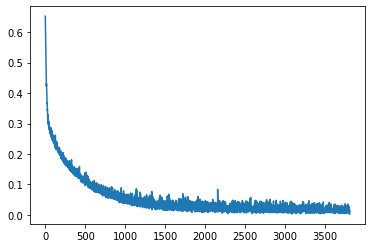

In [189]:
plt.plot(losses)

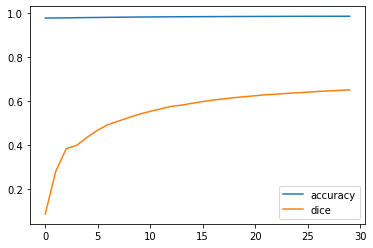

In [190]:
plt.plot([metr[0] for metr in metrics_all], label="accuracy")
plt.plot([metr[1] for metr in metrics_all], label= "dice")
plt.legend()

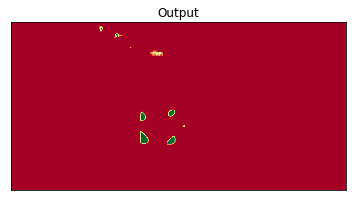

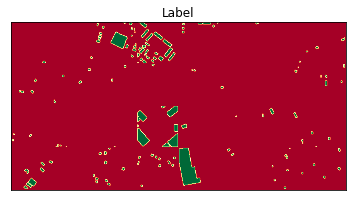

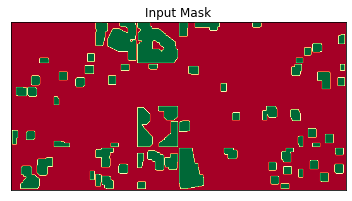

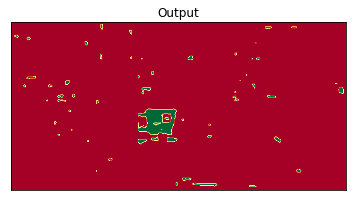

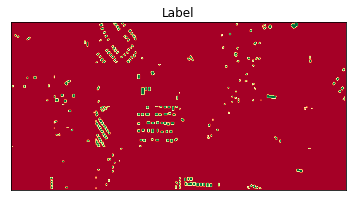

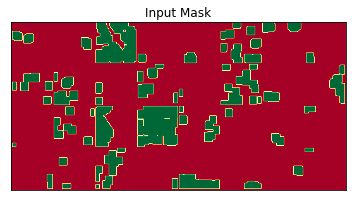

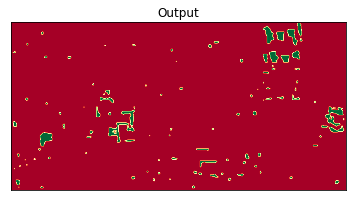

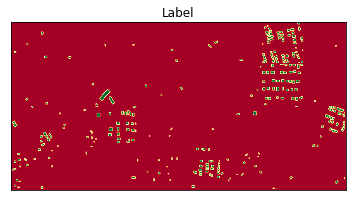

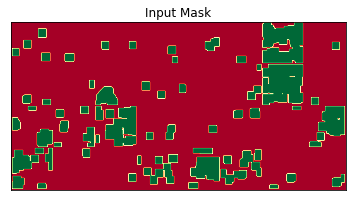

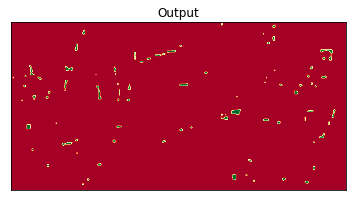

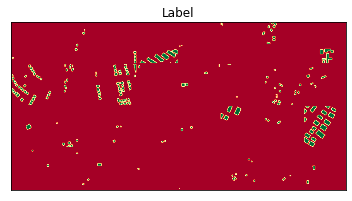

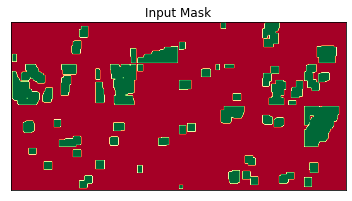

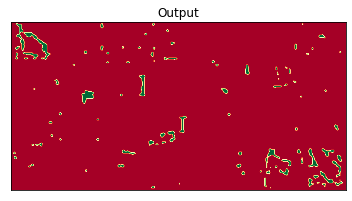

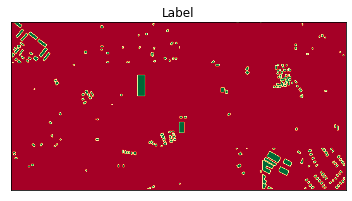

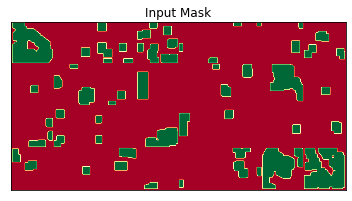

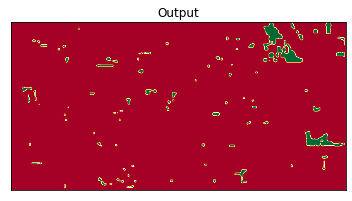

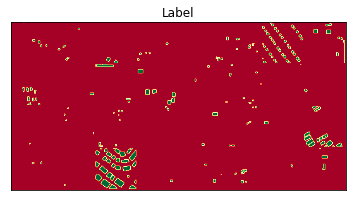

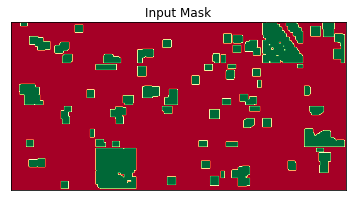

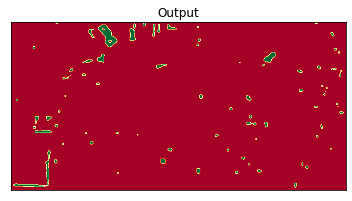

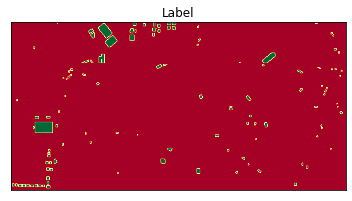

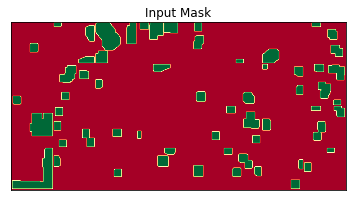

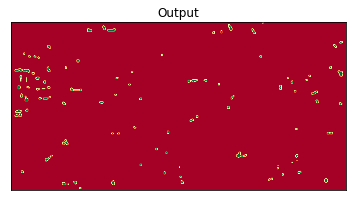

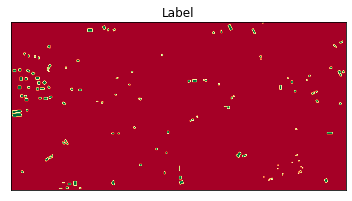

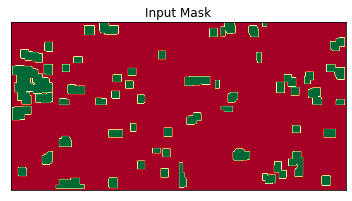

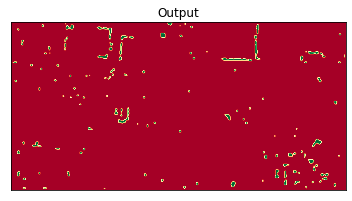

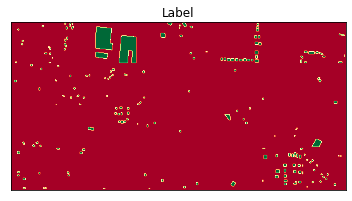

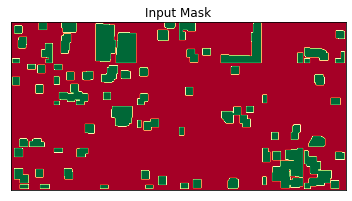

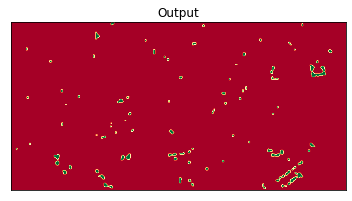

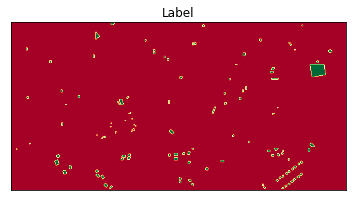

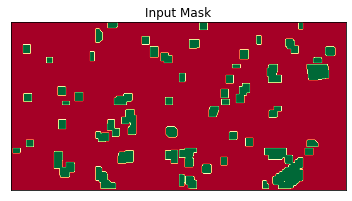

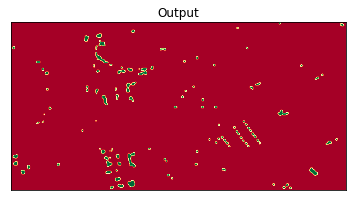

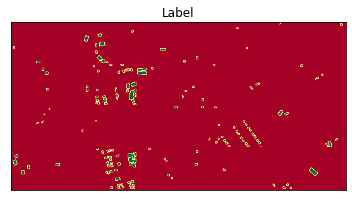

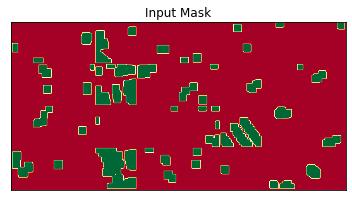

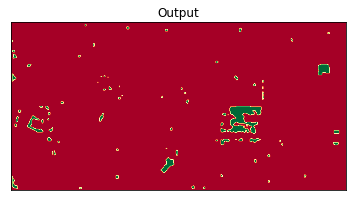

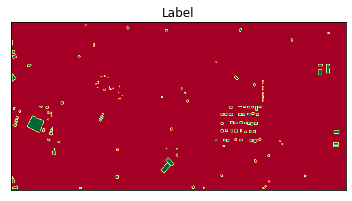

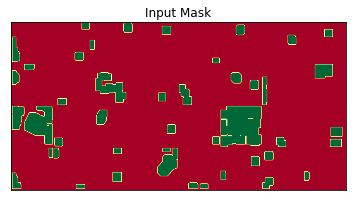

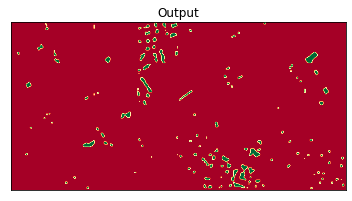

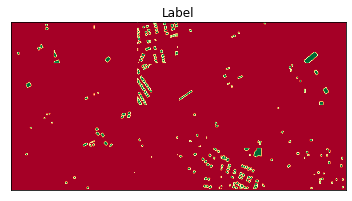

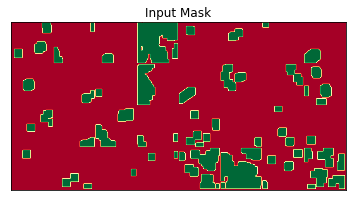

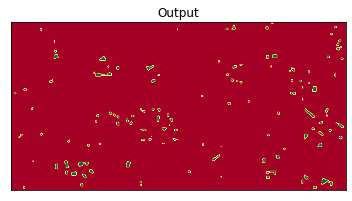

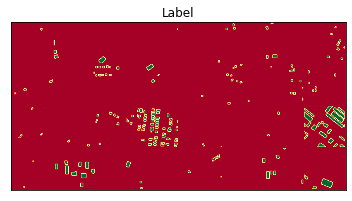

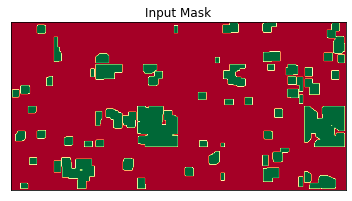

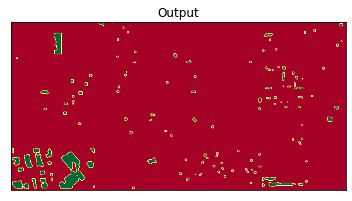

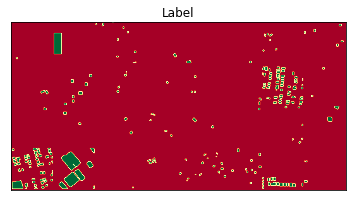

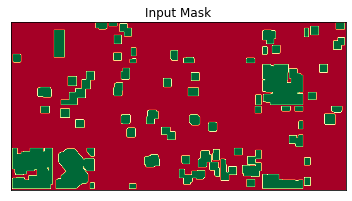

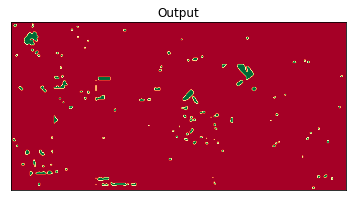

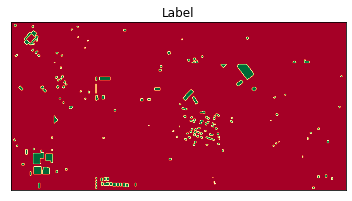

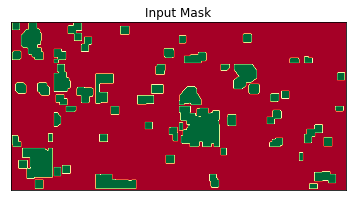

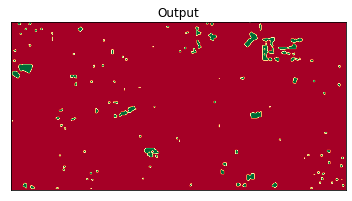

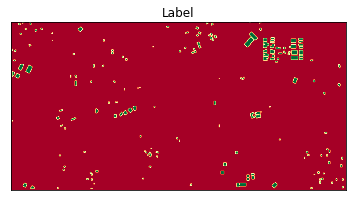

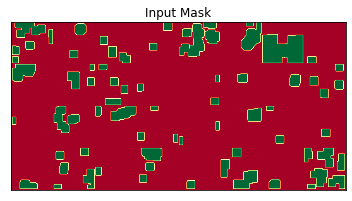

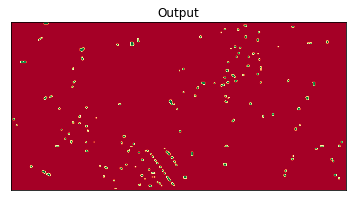

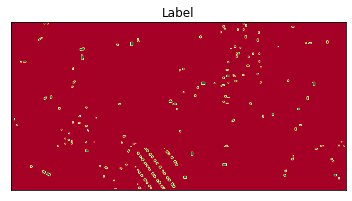

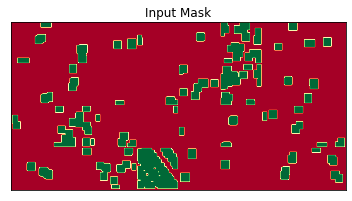

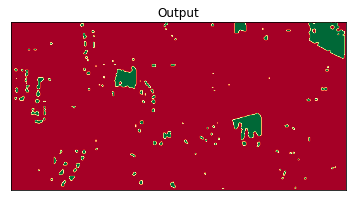

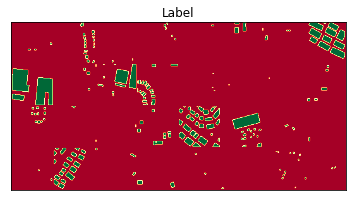

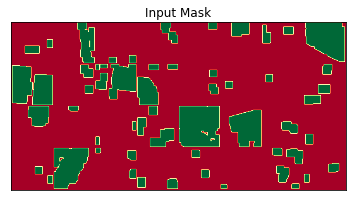

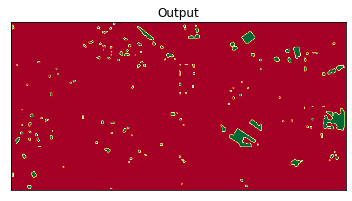

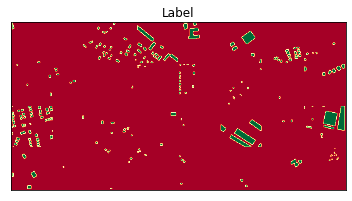

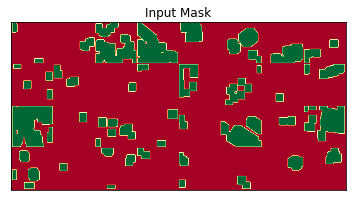

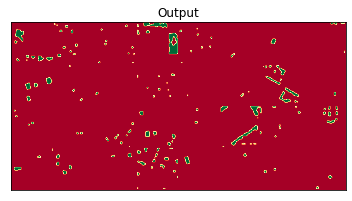

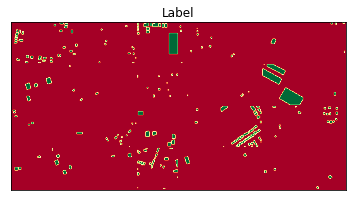

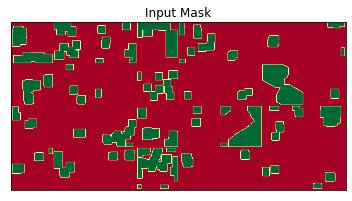

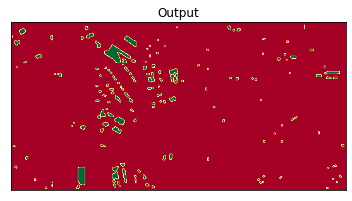

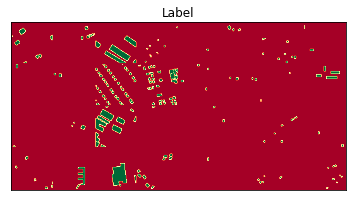

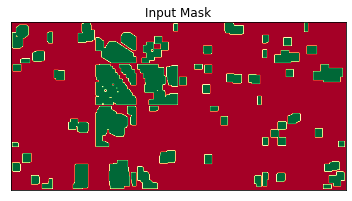

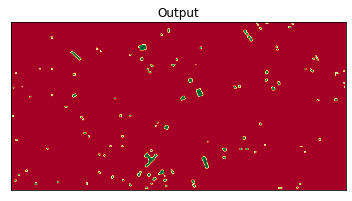

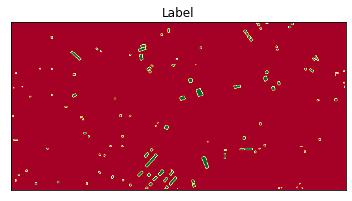

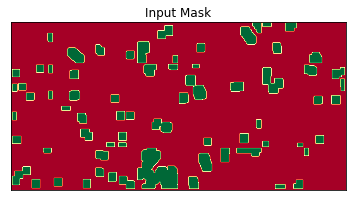

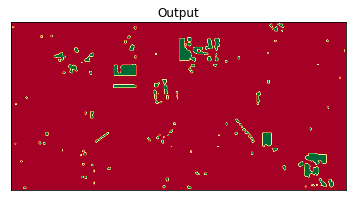

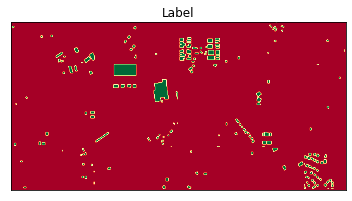

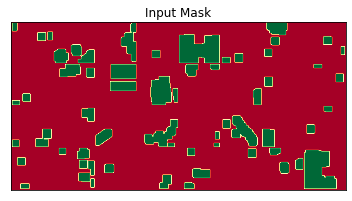

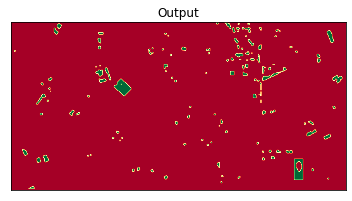

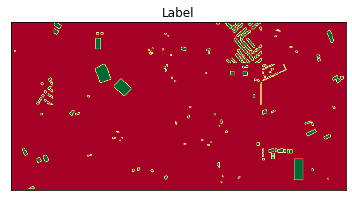

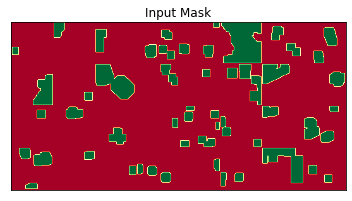

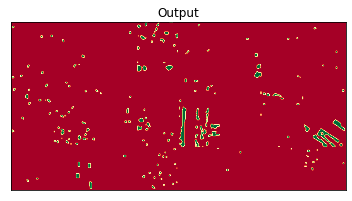

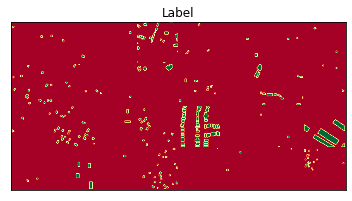

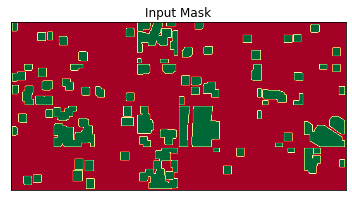

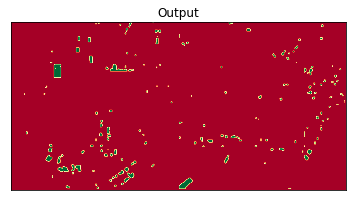

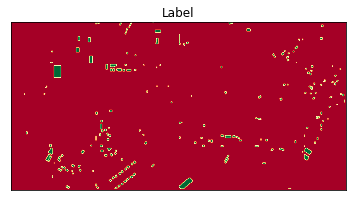

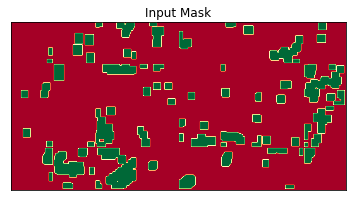

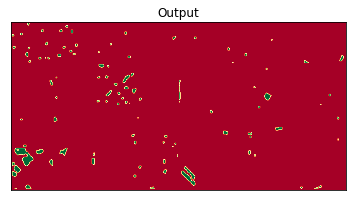

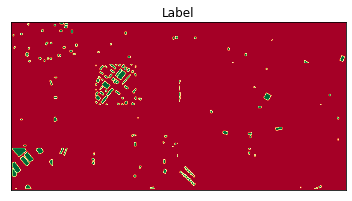

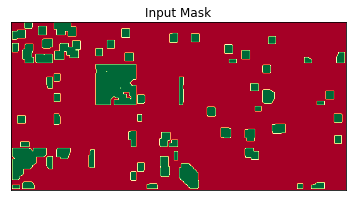

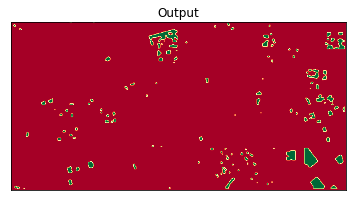

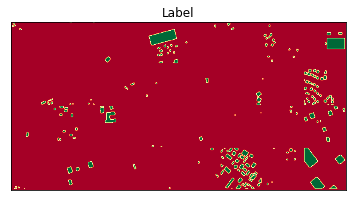

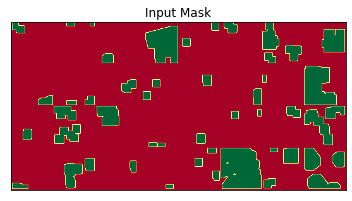

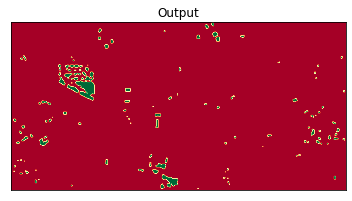

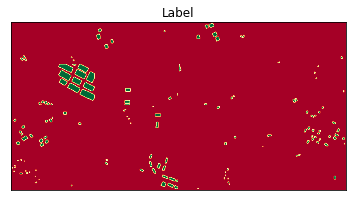

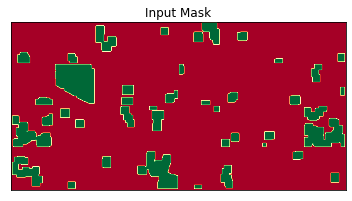

In [191]:
#print(example[0].shape)
for example in examples:
    show_batch_images(example[0],16, "Output")
    show_batch_images(example[1],16, "Label")
    show_batch_images(example[2].type(torch.float32),16, "Input Mask")